# Experiment Tracking with MLFlow (Local)

In this demo we will see how to use MLFlow for tracking experiments, using a toy data set. In the attached lab (below), you will download a larger dataset and attempt to train the best model that you can.

We should first install mlflow, and add it to the requirements.txt file if not done already.

`pip install mlflow` or `python3 -m pip install mlflow`.

You may also need to `pip install setuptools`.

From here, make sure to save this notebook in a specific folder, and ensure you run all command line commands from the same folder.


In [1]:
import mlflow
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score

After loading the libraries, we can first check the mlflow version you have. And, just for fun, let's look at the mlflow UI by running `mlflow ui`. After this, we should do two things:

- set the tracking uri
- create or set the experiment

Setting the tracking uri tells mlflow where to save the results of our experiments. We will first save these locally in a sqlite instance. In a future lab we will set up mlflow to run in GCP.

If you've already created an experiment previously that you'd like to use, you can tell mlflow by setting the experiment. You can also use `set_experiment` even if the experiment has not yet been created - mlflow will first check if the experiment exists, and if not, it will create it for you.


In [2]:
mlflow.__version__

'2.15.1'

Running the below code will create a sqlite database and an mlruns folder in the current directory.


In [3]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("demo-experiment")

2025/03/24 18:54:06 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/03/24 18:54:06 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/Users/benedictneo/usf/mlops/notebooks/mlruns/1', creation_time=1742867646967, experiment_id='1', last_update_time=1742867646967, lifecycle_stage='active', name='demo-experiment', tags={}>

From here, we can load the wine data from sklearn and take a look at it. Then let's play around with some models, without using mlflow for now, to get a sense of why mlflow might come in handy.


In [4]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0


In [5]:
y = wine.target
X = df_wine
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X, y)

DecisionTreeClassifier(max_depth=4)

In [6]:
accuracy_score(y, dt.predict(df_wine))

0.9887640449438202

## Train a Model Using MLFLow

In this section, let's train a simple decision tree model, where we will now adjust the maximum depth (`max_depth`) of the tree, and save the results of each run of the experiment using mlflow. To do so, we need to tell mlflow to start recording. We do this with `start_run`.

The things we might want to record in this simple case are:

- the value of `max_depth`
- the corresponding accuracy of the model

We can also tag each run to make it easier to identify them later.

After running the below code, be sure to check the mlflow UI by running the following in the terminal from the same directory as where you saved this notebook:

`mlflow ui` note that just running this you will not see any of your experiments. You must specify the uri (the place where all of your results are being stored)

`mlflow ui --backend-store-uri sqlite:///mlflow.db`


In [8]:
with mlflow.start_run():
    # log parameters and log metrics
    # parameters: hyperparameters
    # metrics: model performance metrics

    mlflow.set_tags({"Model": "decision-tree", "Train Data": "all-data"})

    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X, y)
    acc = accuracy_score(y, dt.predict(df_wine))

    mlflow.log_param("max_depth", tree_depth)
    mlflow.log_metric("accuracy", acc)

mlflow.end_run()

Let's do it again, but this time we'll use a random forest, which has some other hyperparameters we can tune, which makes keeping track of things a little more complex without a tool like mlflow.


In [9]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run():
    mlflow.set_tags({"Model": "random-forest", "Train Data": "all-data"})

    ntree = 1000
    mtry = 4

    mlflow.log_params({"n_estimators": ntree, "max_features": mtry})

    rf = RandomForestClassifier(n_estimators=ntree, max_features=mtry, oob_score=True)
    rf.fit(X, y)
    acc = rf.oob_score_
    # acc = accuracy_score(y, rf.predict(X))
    mlflow.log_metric("accuracy", acc)

mlflow.end_run()

Typically, in a real-world scenario, you wouldn't change your parameter values manually and re-run your code, you would either use a loop to loop through different parameter values, or you'd use a built-in method for doing cross-validation, of which there are a few. First, let's use a simple loop to run the experiment multiple times, and save the results of each run.


In [9]:
ntrees = [20, 40, 60, 80, 100]
mtrys = [3, 4, 5]
for i in ntrees:
    for j in mtrys:
        with mlflow.start_run():
            mlflow.set_tags({"Model": "random-forest", "Train Data": "all-data"})

            mlflow.log_params({"n_estimators": i, "max_features": j})

            rf = RandomForestClassifier(n_estimators=i, max_features=j, oob_score=True)
            rf.fit(X, y)
            acc = rf.oob_score_
            # acc = accuracy_score(y, rf.predict(X))
            mlflow.log_metric("accuracy", acc)
        mlflow.end_run()

## Training a Model with mlflow and hyperopt

One way of tuning your model is to use the `hyperopt` library. `hyperopt` is a library that does hyperparameter tuning, and does so in a way that makes it easy for mlflow to keep track of the results.

First, install the libraries you don't have, and then load them below. We do not use `hyperopt` much in the class, so if you don't want to add it to your requirements.txt file, you don't have to.

For this exercise, we'll split the data into training and validation, and then we'll train decision trees and random forests and use `hyperopt` to do the hyperparameter tuning and find the best model for us.


In [11]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

From the above we will use `cross_val_score` for our metric, `fmin` is used by `hyperopt` to do the tuning, `tpe` (Tree of Parzen Estimators) is the algorithm used to search the hyperparameter space, `hp` has methods we need to use for defining our search space, `STATUS_OK` is a status message that each run completed, and `Trials` keeps track of each run.


In [12]:
def objective(params):
    with mlflow.start_run():
        classifier_type = params["type"]
        del params["type"]
        if classifier_type == "dt":
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == "rf":
            clf = RandomForestClassifier(**params)
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.end_run()
        return {"loss": -acc, "status": STATUS_OK}


search_space = hp.choice(
    "classifier_type",
    [
        {
            "type": "dt",
            "criterion": hp.choice("dtree_criterion", ["gini", "entropy"]),
            "max_depth": hp.choice(
                "dtree_max_depth", [None, hp.randint("dtree_max_depth_int", 1, 10)]
            ),
            "min_samples_split": hp.randint("dtree_min_samples_split", 2, 10),
        },
        {
            "type": "rf",
            "n_estimators": hp.randint("rf_n_estimators", 20, 500),
            "max_features": hp.randint("rf_max_features", 2, 9),
            "criterion": hp.choice("criterion", ["gini", "entropy"]),
        },
    ],
)

algo = tpe.suggest
trials = Trials()

In [13]:
best_result = fmin(
    fn=objective, space=search_space, algo=algo, max_evals=32, trials=trials
)

100%|██████████| 32/32 [00:20<00:00,  1.59trial/s, best loss: -0.9776190476190475]


In [14]:
best_result

{'classifier_type': 1,
 'criterion': 1,
 'rf_max_features': 5,
 'rf_n_estimators': 388}

### Using Autologging

Rather than manually logging parameters and metrics, mlflow has an autolog feature, which is compatible with a subset of python libraries, such as sklearn. Autologging makes it easy to log all of the important stuff, without having to manually write lines of code to log the parameters. However, sometimes you will want to have finer control over what gets logged, and should instead skip autologging.


In [15]:
with mlflow.start_run():
    mlflow.sklearn.autolog()
    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X_train, y_train)
    mlflow.sklearn.autolog(disable=True)
mlflow.end_run()

2025/03/23 14:55:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


# Artifact Tracking and Model Registry (Local)

In this section we will save some artifacts from our model as we go through the model development process. There are a few things that might be worth saving, such as datasets, plots, and the final model itself that might go into production later.

## Data

First, let's see how we can store our important datasets, in a compressed format, for use for later, for example, in case we get a new request about our model and need to run some analyses (such as "what is the distribution of this feature, but only for this specific subset of data?" or "how did the model do on these particular observations from your validation set?").


In [16]:
import os

os.makedirs("save_data", exist_ok=True)

X_train.to_parquet("save_data/x_train.parquet")

mlflow.log_artifact("save_data/x_train.parquet")

In [17]:
X_test.to_parquet("save_data/x_test.parquet")

mlflow.log_artifacts("save_data/")

You can now go to the mlflow UI, click on the latest run, and select the Artifacts tab. You should see something similar to this:
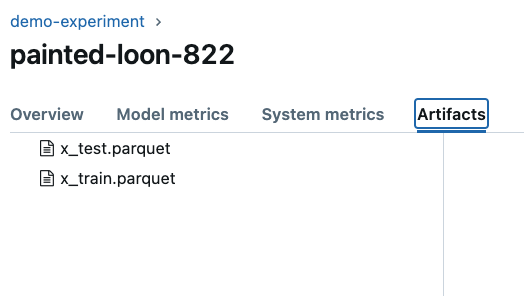


## Images

As part of the model dev process you may end up creating visualizations that can be useful for analysis, or for reporting. You can use mlflow to log the important ones and ignore the rest. After creating the below figure, save into a folder called images, and then you can log whatever is in the `images` folder as an artifact.


array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

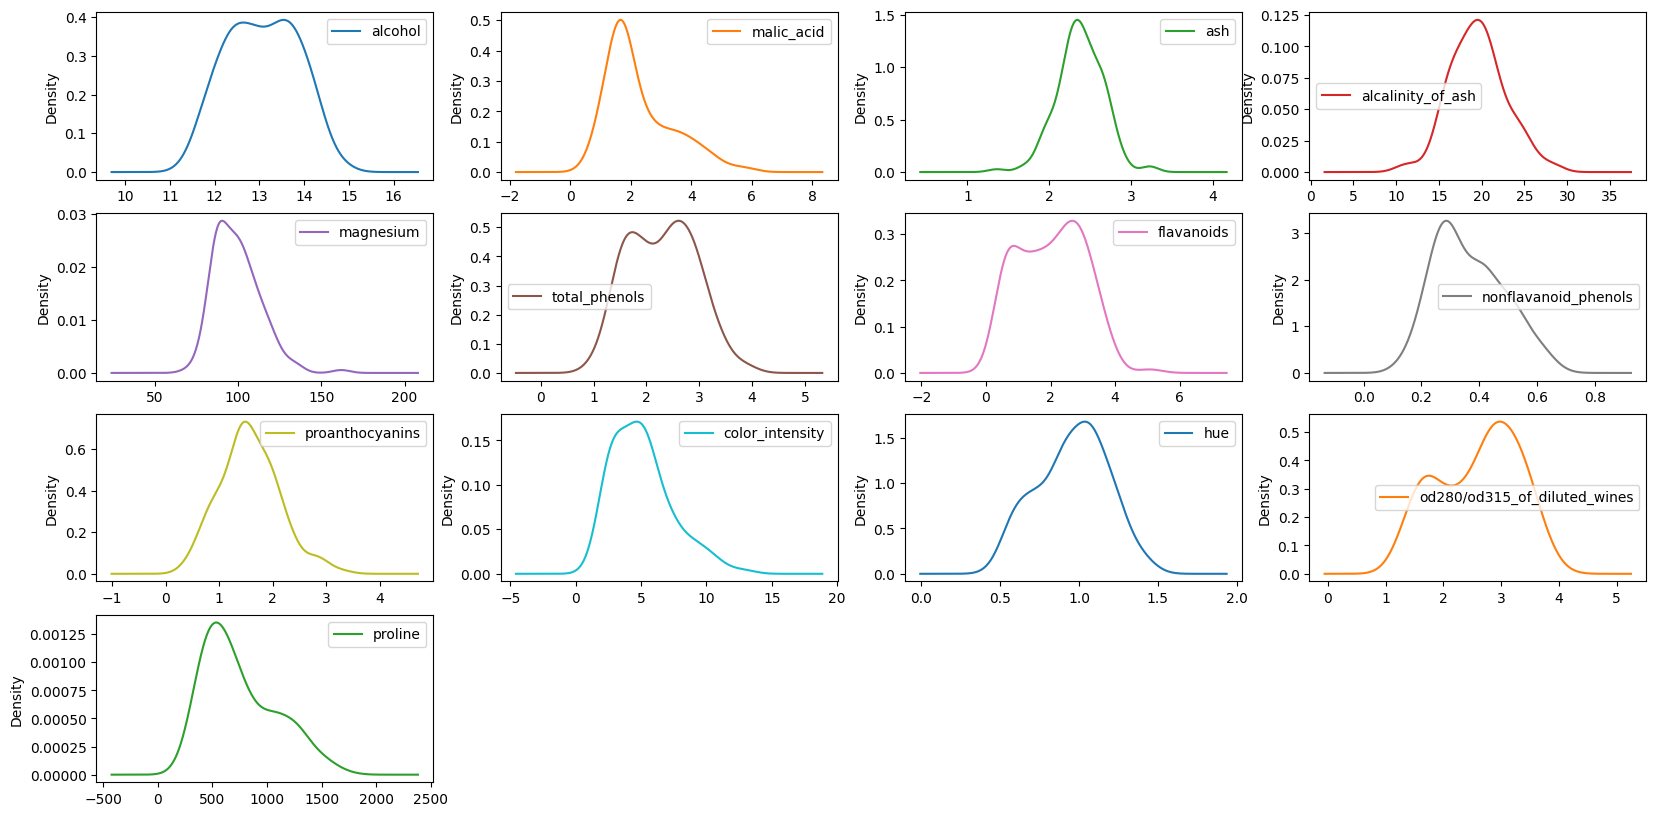

In [18]:
%matplotlib inline
os.makedirs("images", exist_ok=True)
X_train.plot.density(
    subplots=True, figsize=(20, 10), layout=(4, 4), sharey=False, sharex=False
)

In [19]:
mlflow.log_artifacts("images")
mlflow.end_run()

Notice how all of the artifacts were saved in the same run of the experiment. We could have added an `mlflow.end_run()` in between our `log_artifacts` lines to separate runs if we wanted to.


## Model Management and Model Registry

As you are developing your models you may want to save certain versions of the model, or maybe even all of them, so that you don't have to go back and retrain them later. We can do this in mlflow by logging the models, not as artifacts, but as models, using `log_model`.

In this section we'll log a couple of models to see how mlflow handles model management. Above, we used `hyperopt` to train a bunch of models at once. Let's do this again, and log some of the models that we train.

### Logging as an Artifact

First we can try logging a model as an artifact. To do this, we must first save the model itself, which we can do by using the `pickle` library. We then log the model as an artifact like we did with data and images.


In [20]:
import pickle

os.makedirs("../models", exist_ok=True)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

with open("../models/model.pkl", "wb") as f:
    pickle.dump(dt, f)

# First we'll log the model as an artifact
mlflow.log_artifact("../models/model.pkl", artifact_path="my_models")

### Logging as a Model

Logging the model as an artifact only logs the pickle file (the serialized version of the model). It's not really very useful, especially since models contain so much metadata that might be critical to know for deploying the model later. mlflow has a built-in way of logging models specifically, so let's see how to use this, and how it's different from logging models as an artifact.


In [21]:
# Let's do it again, but this time we will log the model using log_model
mlflow.sklearn.log_model(dt, artifact_path="better_models")
mlflow.end_run()

2025/03/23 14:56:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/23 14:56:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Ok, so if you go to the mlflow UI at this point you can see the difference in `log_artifact`, which simply logs the pickle file, and `log_model`, which also gives you information about the environment, required packages, and model flavor.

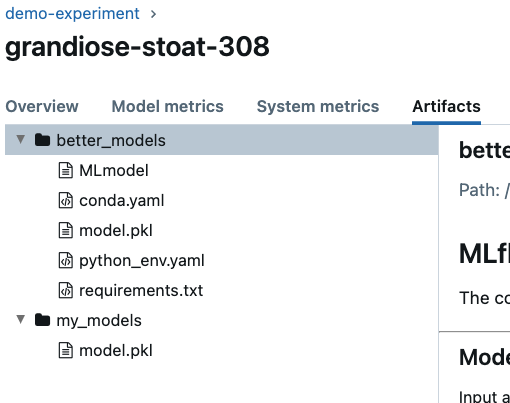

Let's do this one more time, but this time let's use `hyperopt` and log all of the trained models separately. Let's do this in a new experiment called 'demo-experiment2'.


In [22]:
mlflow.set_experiment("demo-experiment2")


def objective(params):
    with mlflow.start_run():
        classifier_type = params["type"]
        del params["type"]
        if classifier_type == "dt":
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == "rf":
            clf = RandomForestClassifier(**params)
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.sklearn.log_model(clf, artifact_path="better_models")
        mlflow.end_run()
        return {"loss": -acc, "status": STATUS_OK}


search_space = hp.choice(
    "classifier_type",
    [
        {
            "type": "dt",
            "criterion": hp.choice("dtree_criterion", ["gini", "entropy"]),
            "max_depth": hp.choice(
                "dtree_max_depth", [None, hp.randint("dtree_max_depth_int", 1, 10)]
            ),
            "min_samples_split": hp.randint("dtree_min_samples_split", 2, 10),
        },
        {
            "type": "rf",
            "n_estimators": hp.randint("rf_n_estimators", 20, 500),
            "max_features": hp.randint("rf_max_features", 2, 9),
            "criterion": hp.choice("criterion", ["gini", "entropy"]),
        },
    ],
)

algo = tpe.suggest
trials = Trials()
best_result = fmin(
    fn=objective, space=search_space, algo=algo, max_evals=32, trials=trials
)

2025/03/23 14:56:03 INFO mlflow.tracking.fluent: Experiment with name 'demo-experiment2' does not exist. Creating a new experiment.


  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

2025/03/23 14:56:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  3%|▎         | 1/32 [00:02<01:02,  2.00s/trial, best loss: -0.9720634920634922]

2025/03/23 14:56:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  6%|▋         | 2/32 [00:03<00:46,  1.57s/trial, best loss: -0.9720634920634922]

2025/03/23 14:56:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  9%|▉         | 3/32 [00:05<00:50,  1.75s/trial, best loss: -0.9720634920634922]

2025/03/23 14:56:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 12%|█▎        | 4/32 [00:06<00:42,  1.52s/trial, best loss: -0.9720634920634922]

2025/03/23 14:56:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 16%|█▌        | 5/32 [00:07<00:37,  1.40s/trial, best loss: -0.9720634920634922]

2025/03/23 14:56:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 19%|█▉        | 6/32 [00:08<00:34,  1.33s/trial, best loss: -0.9720634920634922]

2025/03/23 14:56:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 22%|██▏       | 7/32 [00:10<00:33,  1.36s/trial, best loss: -0.9720634920634922]

2025/03/23 14:56:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 25%|██▌       | 8/32 [00:11<00:31,  1.30s/trial, best loss: -0.9720634920634922]

2025/03/23 14:56:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 28%|██▊       | 9/32 [00:12<00:29,  1.30s/trial, best loss: -0.9720634920634922]

2025/03/23 14:56:17 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 31%|███▏      | 10/32 [00:13<00:27,  1.27s/trial, best loss: -0.9720634920634922]

2025/03/23 14:56:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 34%|███▍      | 11/32 [00:15<00:28,  1.38s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 38%|███▊      | 12/32 [00:17<00:32,  1.62s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 41%|████      | 13/32 [00:20<00:35,  1.85s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 44%|████▍     | 14/32 [00:21<00:29,  1.62s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 47%|████▋     | 15/32 [00:22<00:25,  1.47s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 50%|█████     | 16/32 [00:23<00:21,  1.37s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 53%|█████▎    | 17/32 [00:24<00:20,  1.35s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 56%|█████▋    | 18/32 [00:26<00:22,  1.62s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 59%|█████▉    | 19/32 [00:28<00:19,  1.49s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 62%|██████▎   | 20/32 [00:30<00:20,  1.68s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 66%|██████▌   | 21/32 [00:31<00:17,  1.56s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 69%|██████▉   | 22/32 [00:33<00:16,  1.70s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 72%|███████▏  | 23/32 [00:34<00:13,  1.55s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 75%|███████▌  | 24/32 [00:36<00:13,  1.66s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 78%|███████▊  | 25/32 [00:38<00:12,  1.79s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 81%|████████▏ | 26/32 [00:40<00:10,  1.69s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 84%|████████▍ | 27/32 [00:41<00:08,  1.64s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 88%|████████▊ | 28/32 [00:43<00:06,  1.68s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 91%|█████████ | 29/32 [00:45<00:05,  1.75s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:51 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 94%|█████████▍| 30/32 [00:47<00:03,  1.82s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 97%|█████████▋| 31/32 [00:49<00:01,  1.79s/trial, best loss: -0.9833333333333332]

2025/03/23 14:56:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.

2025/03/23 14:56:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



100%|██████████| 32/32 [00:50<00:00,  1.58s/trial, best loss: -0.9833333333333332]


### Loading Models

Now that models have been logged, you can load specific models back into python for predicting and further analysis. There are two main ways to do this. The mlflow UI actually gives you some instructions, with code that you copy and paste.


In [24]:
logged_model = "runs:/fdd584f706794a4cb29ab098095f759a/better_models"  # replace with one of your models

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: better_models
  flavor: mlflow.sklearn
  run_id: fdd584f706794a4cb29ab098095f759a

In [25]:
sklearn_model = mlflow.sklearn.load_model(logged_model)
sklearn_model

RandomForestClassifier(criterion='entropy', max_features=2, n_estimators=32)

In [26]:
sklearn_model.fit(X_train, y_train)
preds = sklearn_model.predict(X_test)
preds[:5]

array([0, 0, 2, 1, 1])

### Model Registry

Typically, you will **register** your _chosen_ model, the model you plan to put into production. But, sometimes, after you've chosen and registered a model, you may need to replace that model with a new version. For example, the model may have gone into production and started to degrade in performance, and so the model needed to be retrained. Or, you go to deploy your model and notice an error or bug, and now have to go back and retrain it.

In this section let's see how we take our logged models and register them in the model registry, which then can get picked up by the production process, or engineer, for deployment. First, I'll demonstrate how this is done within the UI, but then below I'll show how we can use the python API to do the same thing.


In [28]:
runid = "fdd584f706794a4cb29ab098095f759a"
mod_path = f"runs:/{runid}/artifacts/better_models"
mlflow.register_model(model_uri=mod_path, name="wine_model_from_nb")

Registered model 'wine_model_from_nb' already exists. Creating a new version of this model...
Created version '1' of model 'wine_model_from_nb'.


<ModelVersion: aliases=[], creation_timestamp=1742767047287, current_stage='None', description=None, last_updated_timestamp=1742767047287, name='wine_model_from_nb', run_id='fdd584f706794a4cb29ab098095f759a', run_link=None, source='/Users/benedictneo/usf/mlops/notebooks/mlruns/2/fdd584f706794a4cb29ab098095f759a/artifacts/artifacts/better_models', status='READY', status_message=None, tags={}, user_id=None, version=1>

## Common Issues

- Nothing is appearing in the MLFlow UI: make sure you start the UI from the directory where your notebook is running.
- I installed a library, but I'm getting an error loading it: be sure you installed it in the same environment as where your notebook is running.
- MLFlow doesn't seem to be working at all, I'm just getting errors all over the place: this might be a versioning issue.
- The UI broke, I can't get back to it: `sudo lsof -i :5000 | awk '{print $2}' | tail -n +2 | xargs kill`


# Experiment Tracking and Model Registry Lab

## Overview

In this lab you will each download a new dataset and attempt to train a good model, and use mlflow to keep track of all of your experiments, log your metrics, artifacts and models, and then register a final set of models for "deployment", though we won't actually deploy them anywhere yet.

## Goal

Your goal is **not** to become a master at MLFlow - this is not a course on learning all of the ins and outs of MLFlow. Instead, your goal is to understand when and why it is important to track your model development process (tracking experiments, artifacts and models) and to get into the habit of doing so, and then learn at least the basics of how MLFlow helps you do this so that you can then compare with other tools that are available.

## Data

You can choose your own dataset to use here. It will be helpful to choose a dataset that is already fairly clean and easy to work with. You can even use a dataset that you've used in a previous course. We will do a lot of labs where we do different things with datasets, so if you can find one that is interesting enough for modeling, it should work for most of the rest of the course.

There are tons of places where you can find open public datasets. Choose something that interests you, but don't overthink it.

[Kaggle Datasets](https://www.kaggle.com/datasets)  
[HuggingFace Datasets](https://huggingface.co/docs/datasets/index)  
[Dagshub Datasets](https://dagshub.com/datasets/)  
[UCI](https://archive.ics.uci.edu/ml/datasets.php)  
[Open Data on AWS](https://registry.opendata.aws/)  
[Yelp](https://www.yelp.com/dataset)  
[MovieLens](https://grouplens.org/datasets/movielens/)  
And so many more...

## Instructions

Once you have selected a set of data, create a brand new experiment in MLFlow and begin exploring your data. Do some EDA, clean up, and learn about your data. You do not need to begin tracking anything yet, but you can if you want to (e.g. you can log different versions of your data as you clean it up and do any feature engineering). Do not spend a ton of time on this part. Your goal isn't really to build a great model, so don't spend hours on feature engineering and missing data imputation and things like that.

Once your data is clean, begin training models and tracking your experiments. If you intend to use this same dataset for your final project, then start thinking about what your model might look like when you actually deploy it. For example, when you engineer new features, be sure to save the code that does this, as you will need this in the future. If your final model has 1000 complex features, you might have a difficult time deploying it later on. If your final model takes 15 minutes to train, or takes a long time to score a new batch of data, you may want to think about training a less complex model.

Now, when tracking your experiments, at a _minimum_, you should:

1. Try at least 3 different ML algorithms (e.g. linear regression, decision tree, random forest, etc.).
2. Do hyperparameter tuning for **each** algorithm.
3. Do some very basic feature selection, and repeat the above steps with these reduced sets of features.
4. Identify the top 3 best models and note these down for later.
5. Choose the **final** "best" model that you would deploy or use on future data, stage it (in MLFlow), and run it on the test set to get a final measure of performance. Don't forget to log the test set metric.
6. Be sure you logged the exact training, validation, and testing datasets for the 3 best models, as well as hyperparameter values, and the values of your metrics.
7. Push your code to Github. No need to track the mlruns folder, the images folder, any datasets, or the sqlite database in git.

### Turning It In

In the MLFlow UI, next to the refresh button you should see three vertical dots. Click the dots and then download your experiments as a csv file. Open the csv file in Excel and highlight the rows for your top 3 models from step 4, highlight the run where you applied your best model to the test set, and then save as an excel file. Take a snapshot of the Models page in the MLFLow UI showing the model you staged in step 6 above. Submit the excel file and the snapshot to Canvas.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings("ignore")

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Cardiovascular Disease Risk Prediction")

data = pd.read_csv("../data/cardio/cardio.csv", sep=";")

print("Dataset shape:", data.shape)
print("\nData types:")
print(data.dtypes)
print("\nMissing values:")
print(data.isnull().sum())

print("\nBasic statistics:")
print(data.describe())

2025/03/24 21:03:26 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/03/24 21:03:26 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

Dataset shape: (70000, 13)

Data types:
id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

Missing values:
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Basic statistics:
                 id           age        gender        height        weight  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   49972.419900  19468.865814      1.349571    164.359229     74.205690   
std    28851.302323   2467.251667      0.476838      8.210126     14.395757   
min        0.000000  10798.000000      1.000000     55.000000

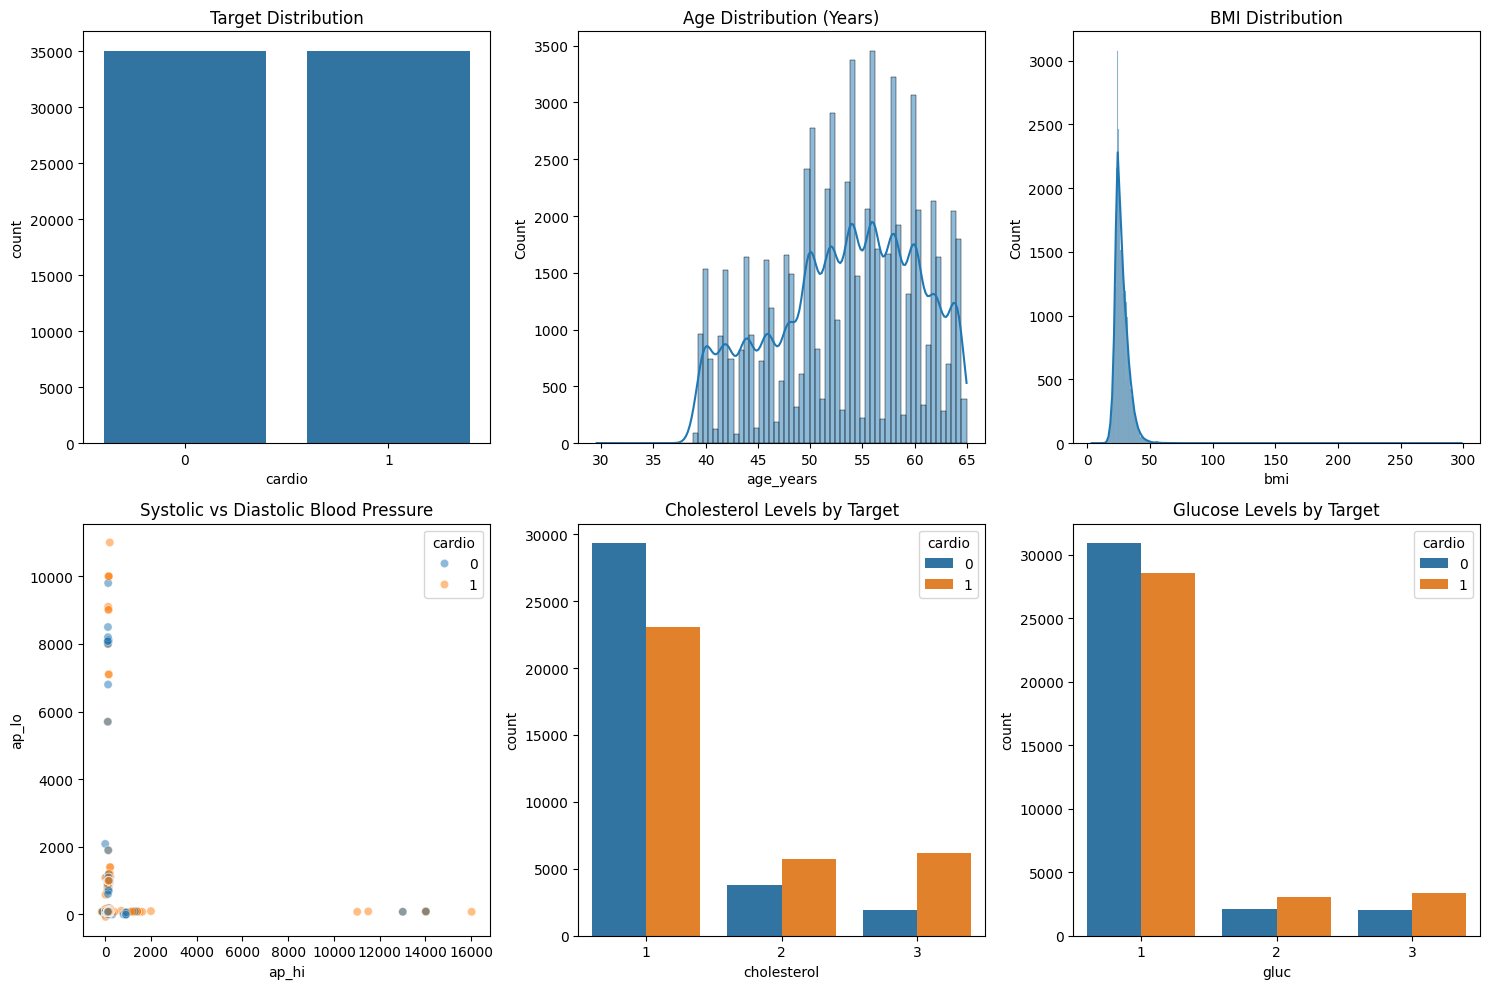

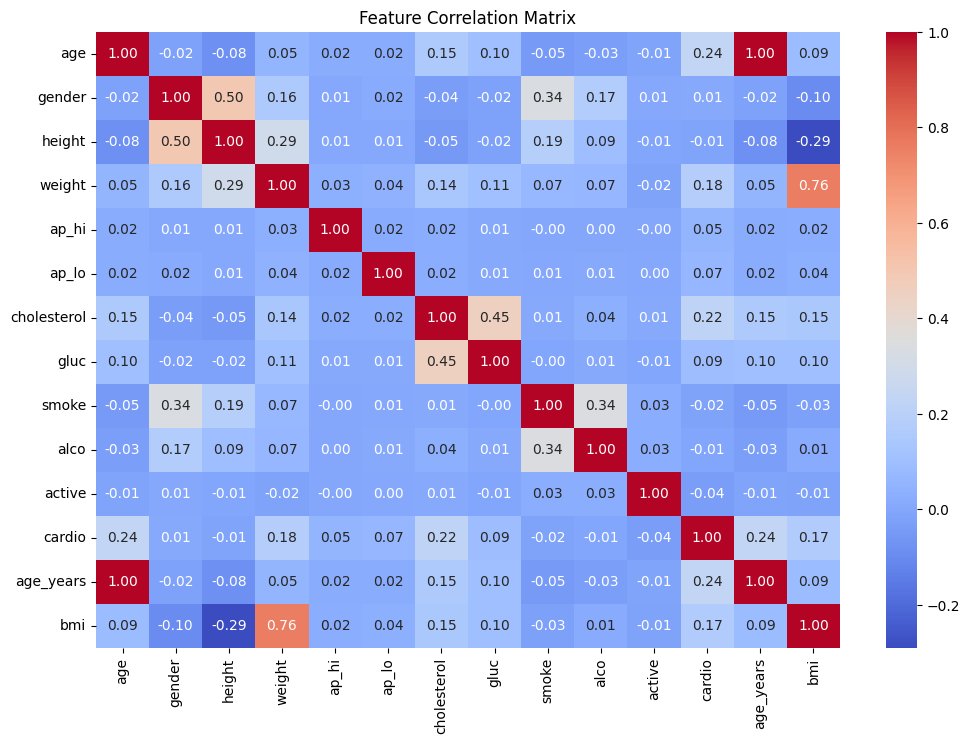

In [2]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.countplot(x="cardio", data=data)
plt.title("Target Distribution")

# Age distribution
plt.subplot(2, 3, 2)
# Convert age from days to years for better interpretability
data["age_years"] = data["age"] / 365
sns.histplot(data["age_years"], kde=True)
plt.title("Age Distribution (Years)")

# BMI distribution
plt.subplot(2, 3, 3)
# Calculate BMI: weight(kg) / (height(m) ^ 2)
data["bmi"] = data["weight"] / ((data["height"] / 100) ** 2)
sns.histplot(data["bmi"], kde=True)
plt.title("BMI Distribution")

# Blood pressure
plt.subplot(2, 3, 4)
sns.scatterplot(x="ap_hi", y="ap_lo", hue="cardio", data=data, alpha=0.5)
plt.title("Systolic vs Diastolic Blood Pressure")

# Cholesterol and glucose levels
plt.subplot(2, 3, 5)
sns.countplot(x="cholesterol", hue="cardio", data=data)
plt.title("Cholesterol Levels by Target")

plt.subplot(2, 3, 6)
sns.countplot(x="gluc", hue="cardio", data=data)
plt.title("Glucose Levels by Target")

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = data.drop("id", axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [3]:
def detect_outliers(df, cols):
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"Outliers in {col}: {len(outliers)} records")


numerical_cols = ["age", "height", "weight", "ap_hi", "ap_lo"]
detect_outliers(data, numerical_cols)

# Remove any implausible values for blood pressure
# Systolic BP range: 70-250
# Diastolic BP range: 40-150
data = data[
    (data["ap_hi"] >= 70)
    & (data["ap_hi"] <= 250)
    & (data["ap_lo"] >= 40)
    & (data["ap_lo"] <= 150)
]

print(f"Dataset shape after removing implausible BP values: {data.shape}")

# Remove extreme height and weight values (adjust thresholds as needed)
data = data[
    (data["height"] >= 140)
    & (data["height"] <= 200)
    & (data["weight"] >= 40)
    & (data["weight"] <= 180)
]

print(f"Dataset shape after removing extreme height/weight values: {data.shape}")

# Drop unnecessary columns
data_cleaned = data.drop(["id", "age_years", "bmi"], axis=1)

# Prepare features and target
X = data_cleaned.drop("cardio", axis=1)
y = data_cleaned["cardio"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv("../data/cardio/train_data.csv", index=False)
val_data.to_csv("../data/cardio/val_data.csv", index=False)
test_data.to_csv("../data/cardio/test_data.csv", index=False)

mlflow.log_artifacts("../data/cardio", "cardio_data")

Outliers in age: 4 records
Outliers in height: 519 records
Outliers in weight: 1819 records
Outliers in ap_hi: 1435 records
Outliers in ap_lo: 4632 records
Dataset shape after removing implausible BP values: (68754, 15)
Dataset shape after removing extreme height/weight values: (68558, 15)
Training set size: (41134, 11)
Validation set size: (13712, 11)
Test set size: (13712, 11)


### 3 models



--- Training Logistic Regression ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/benedictneo/usf/mlops/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benedictneo/usf/mlops/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benedictneo/usf/mlops/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benedictneo/usf/mlops/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benedictneo/usf/mlops/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Logistic Regression - Validation Accuracy: 0.7256, ROC AUC: 0.7902
Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

--- Training Decision Tree ---
Fitting 5 folds for each of 72 candidates, totalling 360 fits


2025/03/24 21:04:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/24 21:04:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Decision Tree - Validation Accuracy: 0.7252, ROC AUC: 0.7883
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

--- Training Random Forest ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025/03/24 21:06:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/24 21:06:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Random Forest - Validation Accuracy: 0.7317, ROC AUC: 0.7994
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

--- Models Comparison ---
                 Model  Validation Accuracy  Validation ROC AUC
2        Random Forest             0.731695            0.799433
0  Logistic Regression             0.725569            0.790217
1        Decision Tree             0.725204            0.788319


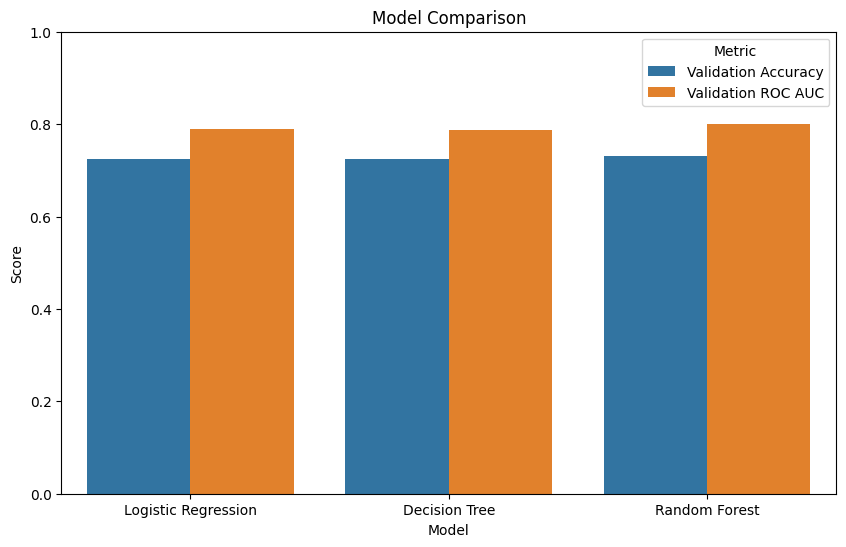

In [4]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

simplefilter("ignore", category=ConvergenceWarning)


def run_experiment(model, param_grid, X_train, X_val, y_train, y_val, model_name):
    mlflow.end_run()

    with mlflow.start_run(run_name=model_name):
        mlflow.log_artifact("../data/cardio/train_data.csv")
        mlflow.log_artifact("../data/cardio/val_data.csv")
        mlflow.log_artifact("../data/cardio/test_data.csv")

        mlflow.log_params({"model_type": model_name})

        grid_search = GridSearchCV(
            model, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
        )

        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        for param, value in best_params.items():
            mlflow.log_param(param, value)

        y_val_pred = best_model.predict(X_val)
        y_val_prob = best_model.predict_proba(X_val)[:, 1]

        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_roc_auc = roc_auc_score(y_val, y_val_prob)

        mlflow.log_metric("validation_accuracy", val_accuracy)
        mlflow.log_metric("validation_roc_auc", val_roc_auc)

        plt.figure(figsize=(8, 6))
        conf_matrix = confusion_matrix(y_val, y_val_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{model_name} Confusion Matrix (Validation)")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.savefig(f"{model_name}_confusion_matrix.png")
        mlflow.log_artifact(f"{model_name}_confusion_matrix.png")
        plt.close()

        report = classification_report(y_val, y_val_pred)
        with open(f"{model_name}_classification_report.txt", "w") as f:
            f.write(report)
        mlflow.log_artifact(f"{model_name}_classification_report.txt")

        if hasattr(best_model, "feature_importances_"):
            feature_importances = pd.DataFrame(
                {
                    "Feature": X_train.columns,
                    "Importance": best_model.feature_importances_,
                }
            ).sort_values("Importance", ascending=False)

            plt.figure(figsize=(10, 6))
            sns.barplot(x="Importance", y="Feature", data=feature_importances)
            plt.title(f"{model_name} Feature Importances")
            plt.tight_layout()
            plt.savefig(f"{model_name}_feature_importances.png")
            mlflow.log_artifact(f"{model_name}_feature_importances.png")
            plt.close()

            feature_importances.to_csv(
                f"{model_name}_feature_importances.csv", index=False
            )
            mlflow.log_artifact(f"{model_name}_feature_importances.csv")

        elif model_name == "Logistic Regression" and hasattr(best_model, "coef_"):
            coefficients = pd.DataFrame(
                {"Feature": X_train.columns, "Coefficient": best_model.coef_[0]}
            ).sort_values("Coefficient", ascending=False)

            plt.figure(figsize=(10, 6))
            sns.barplot(x="Coefficient", y="Feature", data=coefficients)
            plt.title("Logistic Regression Coefficients")
            plt.tight_layout()
            plt.savefig("logistic_regression_coefficients.png")
            mlflow.log_artifact("logistic_regression_coefficients.png")
            plt.close()

            coefficients.to_csv("logistic_regression_coefficients.csv", index=False)
            mlflow.log_artifact("logistic_regression_coefficients.csv")

        # Log the model
        mlflow.sklearn.log_model(best_model, model_name)

        print(
            f"{model_name} - Validation Accuracy: {val_accuracy:.4f}, ROC AUC: {val_roc_auc:.4f}"
        )
        print(f"Best parameters: {best_params}")

        result = (best_model, val_accuracy, val_roc_auc)

    mlflow.end_run()
    return result


# 1. Logistic Regression
print("\n--- Training Logistic Regression ---")
lr_param_grid = {
    "C": [0.01, 0.1, 1.0],
    "solver": ["liblinear", "saga"],
    "penalty": ["l1", "l2"],
}

lr_model = LogisticRegression(random_state=42)
lr_best_model, lr_val_accuracy, lr_val_roc_auc = run_experiment(
    lr_model, lr_param_grid, X_train, X_val, y_train, y_val, "Logistic Regression"
)

# 2. Decision Tree
print("\n--- Training Decision Tree ---")
dt_param_grid = {
    "max_depth": [None, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"],
}

dt_model = DecisionTreeClassifier(random_state=42)
dt_best_model, dt_val_accuracy, dt_val_roc_auc = run_experiment(
    dt_model, dt_param_grid, X_train, X_val, y_train, y_val, "Decision Tree"
)

# 3. Random Forest
print("\n--- Training Random Forest ---")
rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

rf_model = RandomForestClassifier(random_state=42)
rf_best_model, rf_val_accuracy, rf_val_roc_auc = run_experiment(
    rf_model, rf_param_grid, X_train, X_val, y_train, y_val, "Random Forest"
)


# Compare models
models_comparison = pd.DataFrame(
    {
        "Model": ["Logistic Regression", "Decision Tree", "Random Forest"],
        "Validation Accuracy": [lr_val_accuracy, dt_val_accuracy, rf_val_accuracy],
        "Validation ROC AUC": [lr_val_roc_auc, dt_val_roc_auc, rf_val_roc_auc],
    }
)

print("\n--- Models Comparison ---")
print(models_comparison.sort_values("Validation ROC AUC", ascending=False))

# Visualize model comparison
plt.figure(figsize=(10, 6))
models_comparison_melted = pd.melt(
    models_comparison, id_vars="Model", var_name="Metric", value_name="Score"
)
sns.barplot(x="Model", y="Score", hue="Metric", data=models_comparison_melted)
plt.title("Model Comparison")
plt.ylim(0, 1)
plt.savefig("model_comparison.png")
plt.show()

### feature selection


Selected top 6 features: ['age', 'weight', 'ap_hi', 'height', 'ap_lo', 'cholesterol']

--- Training Logistic Regression with Selected Features ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/benedictneo/usf/mlops/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benedictneo/usf/mlops/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benedictneo/usf/mlops/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benedictneo/usf/mlops/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benedictneo/usf/mlops/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Logistic Regression (Selected Features) - Validation Accuracy: 0.7261, ROC AUC: 0.7889
Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

--- Training Decision Tree with Selected Features ---
Fitting 5 folds for each of 72 candidates, totalling 360 fits


2025/03/24 21:06:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/24 21:06:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Decision Tree (Selected Features) - Validation Accuracy: 0.7267, ROC AUC: 0.7887
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

--- Training Random Forest with Selected Features ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025/03/24 21:08:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/24 21:08:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Random Forest (Selected Features) - Validation Accuracy: 0.7309, ROC AUC: 0.7971
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

--- All Models Comparison ---
                            Model  Validation Accuracy  Validation ROC AUC
2            Random Forest (Full)             0.731695            0.799433
5        Random Forest (Selected)             0.730893            0.797111
0      Logistic Regression (Full)             0.725569            0.790217
3  Logistic Regression (Selected)             0.726079            0.788886
4        Decision Tree (Selected)             0.726663            0.788712
1            Decision Tree (Full)             0.725204            0.788319


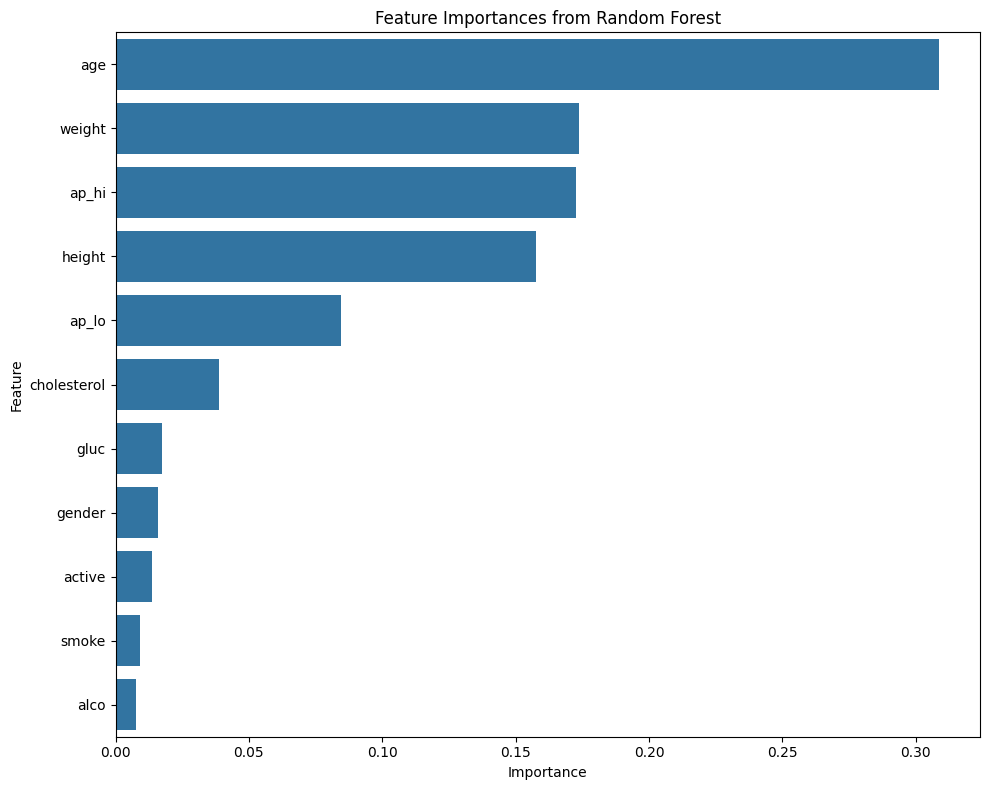

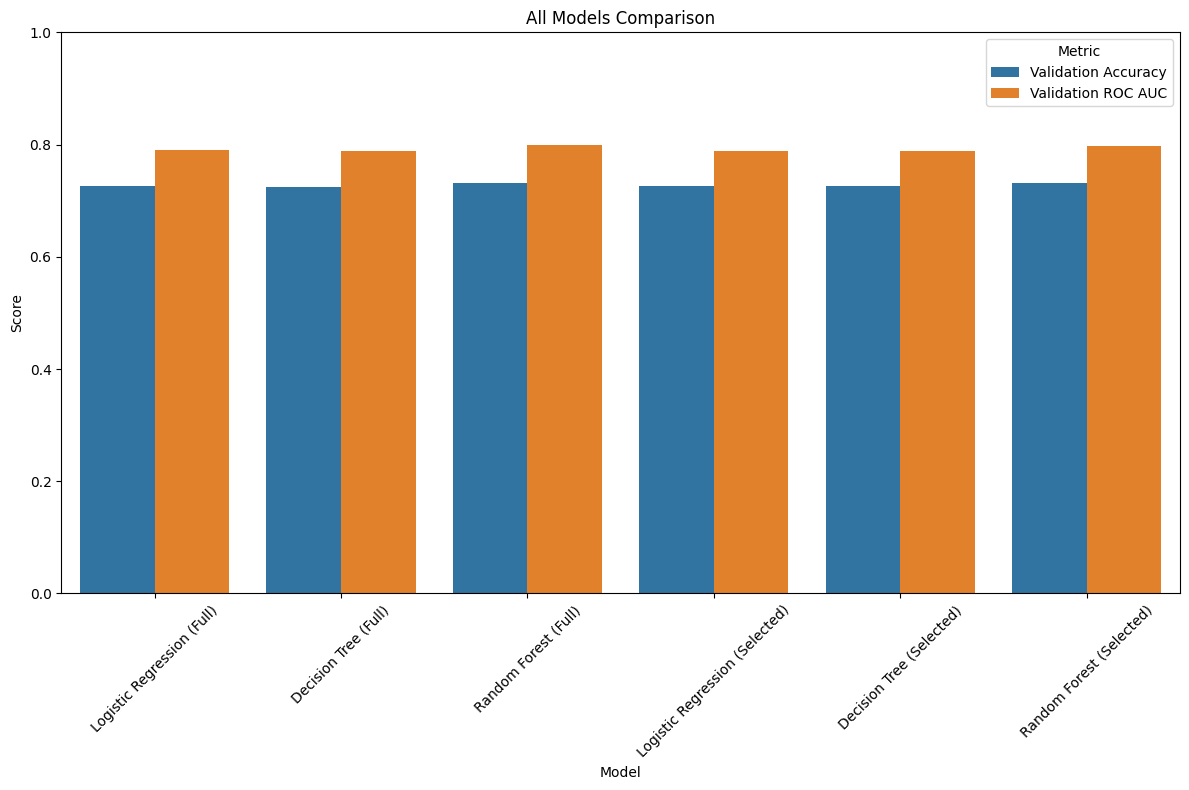

In [5]:
import warnings

warnings.filterwarnings("ignore")

with mlflow.start_run(run_name="Feature Selection"):
    mlflow.log_artifact("../data/cardio/train_data.csv", "original_data")
    mlflow.log_artifact("../data/cardio/val_data.csv", "original_data")
    mlflow.log_artifact("../data/cardio/test_data.csv", "original_data")

    feature_selector = RandomForestClassifier(n_estimators=100, random_state=42)
    feature_selector.fit(X_train, y_train)

    feature_importances = pd.DataFrame(
        {
            "Feature": X_train.columns,
            "Importance": feature_selector.feature_importances_,
        }
    ).sort_values("Importance", ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x="Importance", y="Feature", data=feature_importances)
    plt.title("Feature Importances from Random Forest")
    plt.tight_layout()
    plt.savefig("feature_importances.png")
    mlflow.log_artifact("feature_importances.png")

    top_features = feature_importances.head(6)["Feature"].tolist()
    mlflow.log_param("selected_features", top_features)

    X_train_selected = X_train[top_features]
    X_val_selected = X_val[top_features]
    X_test_selected = X_test[top_features]

    train_data_selected = pd.concat([X_train_selected, y_train], axis=1)
    val_data_selected = pd.concat([X_val_selected, y_val], axis=1)
    test_data_selected = pd.concat([X_test_selected, y_test], axis=1)

    train_data_selected.to_csv("../data/cardio/train_data_selected.csv", index=False)
    val_data_selected.to_csv("../data/cardio/val_data_selected.csv", index=False)
    test_data_selected.to_csv("../data/cardio/test_data_selected.csv", index=False)

    mlflow.log_artifact(
        "../data/cardio/train_data_selected.csv", "selected_features_data"
    )
    mlflow.log_artifact(
        "../data/cardio/val_data_selected.csv", "selected_features_data"
    )
    mlflow.log_artifact(
        "../data/cardio/test_data_selected.csv", "selected_features_data"
    )

    print(f"Selected top {len(top_features)} features: {top_features}")


def run_experiment_selected_features(
    model, param_grid, X_train, X_val, y_train, y_val, model_name
):
    with mlflow.start_run(run_name=f"{model_name} - Selected Features"):
        mlflow.log_artifact("../data/cardio/train_data_selected.csv")
        mlflow.log_artifact("../data/cardio/val_data_selected.csv")
        mlflow.log_artifact("../data/cardio/test_data_selected.csv")

        mlflow.log_params(
            {
                "model_type": model_name,
                "feature_selection": "Top 6 features from Random Forest",
            }
        )
        mlflow.log_param("selected_features", top_features)

        grid_search = GridSearchCV(
            model, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
        )

        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        for param, value in best_params.items():
            mlflow.log_param(param, value)

        y_val_pred = best_model.predict(X_val)
        y_val_prob = best_model.predict_proba(X_val)[:, 1]

        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_roc_auc = roc_auc_score(y_val, y_val_prob)

        mlflow.log_metric("validation_accuracy", val_accuracy)
        mlflow.log_metric("validation_roc_auc", val_roc_auc)

        plt.figure(figsize=(8, 6))
        conf_matrix = confusion_matrix(y_val, y_val_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{model_name} Confusion Matrix (Selected Features)")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.savefig(f"{model_name}_selected_features_confusion_matrix.png")
        mlflow.log_artifact(f"{model_name}_selected_features_confusion_matrix.png")
        plt.close()

        mlflow.sklearn.log_model(best_model, f"{model_name}_selected_features")

        print(
            f"{model_name} (Selected Features) - Validation Accuracy: {val_accuracy:.4f}, ROC AUC: {val_roc_auc:.4f}"
        )
        print(f"Best parameters: {best_params}")

        return best_model, val_accuracy, val_roc_auc


# 1. Logistic Regression with Selected Features
print("\n--- Training Logistic Regression with Selected Features ---")
lr_model_selected = LogisticRegression(random_state=42)
lr_best_model_selected, lr_val_accuracy_selected, lr_val_roc_auc_selected = (
    run_experiment_selected_features(
        lr_model_selected,
        lr_param_grid,
        X_train_selected,
        X_val_selected,
        y_train,
        y_val,
        "Logistic Regression",
    )
)

# 2. Decision Tree with Selected Features
print("\n--- Training Decision Tree with Selected Features ---")
dt_model_selected = DecisionTreeClassifier(random_state=42)
dt_best_model_selected, dt_val_accuracy_selected, dt_val_roc_auc_selected = (
    run_experiment_selected_features(
        dt_model_selected,
        dt_param_grid,
        X_train_selected,
        X_val_selected,
        y_train,
        y_val,
        "Decision Tree",
    )
)

# 3. Random Forest with Selected Features
print("\n--- Training Random Forest with Selected Features ---")
rf_model_selected = RandomForestClassifier(random_state=42)
rf_best_model_selected, rf_val_accuracy_selected, rf_val_roc_auc_selected = (
    run_experiment_selected_features(
        rf_model_selected,
        rf_param_grid,
        X_train_selected,
        X_val_selected,
        y_train,
        y_val,
        "Random Forest",
    )
)

# Compare all models (full feature set and selected features)
all_models_comparison = pd.DataFrame(
    {
        "Model": [
            "Logistic Regression (Full)",
            "Decision Tree (Full)",
            "Random Forest (Full)",
            "Logistic Regression (Selected)",
            "Decision Tree (Selected)",
            "Random Forest (Selected)",
        ],
        "Validation Accuracy": [
            lr_val_accuracy,
            dt_val_accuracy,
            rf_val_accuracy,
            lr_val_accuracy_selected,
            dt_val_accuracy_selected,
            rf_val_accuracy_selected,
        ],
        "Validation ROC AUC": [
            lr_val_roc_auc,
            dt_val_roc_auc,
            rf_val_roc_auc,
            lr_val_roc_auc_selected,
            dt_val_roc_auc_selected,
            rf_val_roc_auc_selected,
        ],
    }
)

print("\n--- All Models Comparison ---")
print(all_models_comparison.sort_values("Validation ROC AUC", ascending=False))

# Visualize all models comparison
plt.figure(figsize=(12, 8))
all_models_comparison_melted = pd.melt(
    all_models_comparison, id_vars="Model", var_name="Metric", value_name="Score"
)
sns.barplot(x="Model", y="Score", hue="Metric", data=all_models_comparison_melted)
plt.title("All Models Comparison")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("all_models_comparison.png")
plt.show()

### best model


In [6]:
from sklearn.metrics import roc_curve

top_models = all_models_comparison.sort_values(
    "Validation ROC AUC", ascending=False
).head(3)
print("\n--- Top 3 Models ---")
print(top_models)

best_model_name = top_models.iloc[0]["Model"]
best_model_accuracy = top_models.iloc[0]["Validation Accuracy"]
best_model_roc_auc = top_models.iloc[0]["Validation ROC AUC"]

print(f"\nBest Model: {best_model_name}")
print(f"Validation Accuracy: {best_model_accuracy:.4f}")
print(f"Validation ROC AUC: {best_model_roc_auc:.4f}")

if "Random Forest" in best_model_name:
    if "Selected" in best_model_name:
        best_model = rf_best_model_selected
        X_test_final = X_test_selected
    else:
        best_model = rf_best_model
        X_test_final = X_test
elif "Decision Tree" in best_model_name:
    if "Selected" in best_model_name:
        best_model = dt_best_model_selected
        X_test_final = X_test_selected
    else:
        best_model = dt_best_model
        X_test_final = X_test
else:
    if "Selected" in best_model_name:
        best_model = lr_best_model_selected
        X_test_final = X_test_selected
    else:
        best_model = lr_best_model
        X_test_final = X_test

with mlflow.start_run(run_name=f"Best Model - {best_model_name} - Test Evaluation"):
    mlflow.log_param("model_name", best_model_name)
    mlflow.log_param("validation_accuracy", best_model_accuracy)
    mlflow.log_param("validation_roc_auc", best_model_roc_auc)

    y_test_pred = best_model.predict(X_test_final)
    y_test_prob = best_model.predict_proba(X_test_final)[:, 1]

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_prob)

    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    plt.figure(figsize=(8, 6))
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{best_model_name} Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"best_model_test_confusion_matrix.png")
    mlflow.log_artifact(f"best_model_test_confusion_matrix.png")
    plt.close()

    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{best_model_name} ROC Curve (Test Set)")
    plt.legend()
    plt.savefig(f"best_model_test_roc_curve.png")
    mlflow.log_artifact(f"best_model_test_roc_curve.png")
    plt.close()

    test_report = classification_report(y_test, y_test_pred)
    with open(f"best_model_test_classification_report.txt", "w") as f:
        f.write(test_report)
    mlflow.log_artifact(f"best_model_test_classification_report.txt")

    model_name = best_model_name.replace(" ", "_").replace("(", "").replace(")", "")
    mlflow.sklearn.log_model(best_model, f"best_model_{model_name}")

    print(f"\n--- Test Set Evaluation for {best_model_name} ---")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test ROC AUC: {test_roc_auc:.4f}")

    model_uri = f"runs:/{mlflow.active_run().info.run_id}/best_model_{model_name}"
    model_details = mlflow.register_model(
        model_uri=model_uri, name=f"CardioDiseasePrediction_{model_name}"
    )

    client = mlflow.tracking.MlflowClient()
    client.transition_model_version_stage(
        name=model_details.name, version=model_details.version, stage="Staging"
    )

    print(
        f"\nModel '{model_details.name}' version {model_details.version} registered and staged as 'Staging'"
    )



--- Top 3 Models ---
                        Model  Validation Accuracy  Validation ROC AUC
2        Random Forest (Full)             0.731695            0.799433
5    Random Forest (Selected)             0.730893            0.797111
0  Logistic Regression (Full)             0.725569            0.790217

Best Model: Random Forest (Full)
Validation Accuracy: 0.7317
Validation ROC AUC: 0.7994


2025/03/24 21:09:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/24 21:09:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



--- Test Set Evaluation for Random Forest (Full) ---
Test Accuracy: 0.7402
Test ROC AUC: 0.8045

Model 'CardioDiseasePrediction_Random_Forest_Full' version 1 registered and staged as 'Staging'


Successfully registered model 'CardioDiseasePrediction_Random_Forest_Full'.
Created version '1' of model 'CardioDiseasePrediction_Random_Forest_Full'.
